In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import segmenter as pb
import sam3d as s3d
import open3d as o3d
from psdframe import Frame
from psdstaticdataset import StaticDataset
from pathlib import Path
from matplotlib import pyplot as plt
from initializerdefs import SceneSetup
from segment_anything import build_sam, SamAutomaticMaskGenerator
from util import Voxelize, num_to_natural

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


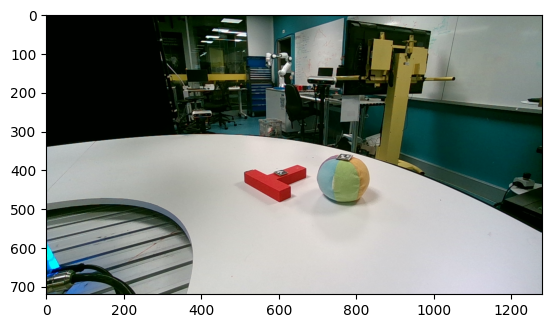

In [2]:
DS_PATH = Path("/home/david/projects/embodied_gaussians/datasets/real/multiple1_aruco/modelling/static")
d = StaticDataset(DS_PATH / "transforms.json")
intermediate_outputs_path = Path("/home/david/projects/SegmentAnything3D/outputs/notebook")
scene = SceneSetup.load(DS_PATH / "scene.pkl")

plt.imshow(d.frames[0].color.cpu().numpy())
plt.show()

In [4]:
result = pb.initialize_scene(d, scene, intermediate_outputs_path)

merging 5 point clouds
merging 3 point clouds
merging 2 point clouds


TypeError: only integer scalar arrays can be converted to a scalar index

In [15]:
# create spheres from particles, and move to particles position
object_idx = 1

gaussians = result.objects[object_idx].gaussians
particles = result.objects[object_idx].particles
spheres = []
print(len(spheres), len(particles.xyz))
for xyz, radius in zip(particles.xyz, particles.radius):
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
    sphere.translate(xyz)
    spheres.append(sphere)
#o3d.visualization.draw_geometries([*spheres], mesh_show_back_face=True)

from mesh_to_gaussians import splats_to_oriented_discs
discs = splats_to_oriented_discs(gaussians.xyz, gaussians.scaling, gaussians.rotations, gaussians.colors, resolution=12)

0 85


In [16]:
o3d.visualization.draw_geometries([*spheres], mesh_show_back_face=True)

In [18]:
o3d.visualization.draw_geometries([*discs, *spheres], mesh_show_back_face=True)